In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '/home/acy/PCML/projects/project1/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

DATA_TEST_PATH = '/home/acy/PCML/projects/project1/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [3]:
from helpers import standardize

def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    N = x.shape[0]
    D = x.shape[1]
    
    phi = np.zeros((N,D*degree))
    col = 0
    for i in range(1,degree+1):
        for j in range(0,D):
            phi[:,col]=x[:,j]**i
            col=col+1
    return phi

def add_feature(x,f):
    N = x.shape[0]
    D = x.shape[1]
    F = f.shape[1]
    
    res = np.zeros((N,D+F))
    res[:,0:D] = np.copy(x)
    for i in range(0,F):
        res[:,D+i]=f[:,i]
    return res

def find_outlier(tX):
    N = tX.shape[0]
    D = tX.shape[1]
    outlier_index = [[] for i in range(D)]
    for d in range(D):
        for n in range(N):
            if tX[n,d] == -999.0:
                outlier_index[d].append(n)     
    return outlier_index

def normalize(x,outlier_index):
    N = x.shape[0]
    D = x.shape[1]
    mean = np.empty([D])
    std = np.empty([D])
    for d in range(D):
        print(d)
        clean_column = []
        for i in range(N):
            if i not in outlier_index[d]:
                print(i)
                clean_column.append(x[i,d])
        mean[d] = np.mean(clean_column)
        std[d] = np.std(clean_column)
    x = x - mean
    x[:, std>0] = x[:, std>0] / std[std>0]
    return x

def clean_data(tX,outlier_index):
    D = tX.shape[1]
    tX_clean =np.copy(tX)
    for d in range(D):
        for n in outlier_index[d%30]:
            tX_clean[n,d] = 0 
    return tX_clean

def append_ones(x):
    tx = np.hstack((np.ones((x.shape[0],1)), x))
    return tx

# def append_cross_product(x):
#     N = x.shape[0]
#     D = x.shape[1]
    
#     ind1 = [2, 3, 4, 7, 9, 12, 15, 16, 18, 23, 25, 27, 29]
#     ind2 = [3, 5, 8, 10, 11, 13, 14, 17, 19, 21, 24, 26, 28]
    
#     F = len(ind1)
    
#     res = np.zeros((N,D+F))
#     res[:,0:D] = np.copy(x)
#     for i in range(0,F):
#         res[:,D+i]=np.multiply(x[:,ind1[i]],x[:,ind2[i]])
#     return res
    
def feature_process(tX_train, tX_test, poly_degree):
    N_tr = tX_train.shape[0]
    N_te = tX_test.shape[0]
    tX_merged = np.append(tX_train,tX_test,axis=0)
    
    print('finding outliers')
    outlier_index= find_outlier(tX_merged)
    
    print('building polynomials')
    phiX_merged = build_poly(tX_merged, poly_degree)
    phiX_merged = add_feature(phiX_merged,np.sqrt(np.abs(tX_merged)))
    phiX_merged = add_feature(phiX_merged,np.log(np.abs(tX_merged)+0.01))
    phiX_merged = add_feature(phiX_merged,np.tanh(tX_merged))
    phiX_merged = add_feature(phiX_merged,np.fft.fft(tX_merged,axis=1).real)

    print('cleaning the outliers')
    phiX_merged = clean_data(phiX_merged,outlier_index)
    print('normalizing the features')
    phiX_merged, _, _ = standardize(phiX_merged, None, None)
    print('cleaning the outliers once more')
    phiX_merged = clean_data(phiX_merged,outlier_index)
    print('appending')
    phiX_merged = append_ones(phiX_merged)
    return phiX_merged[0:N_tr,:], phiX_merged[N_tr:N_tr+N_te,:]


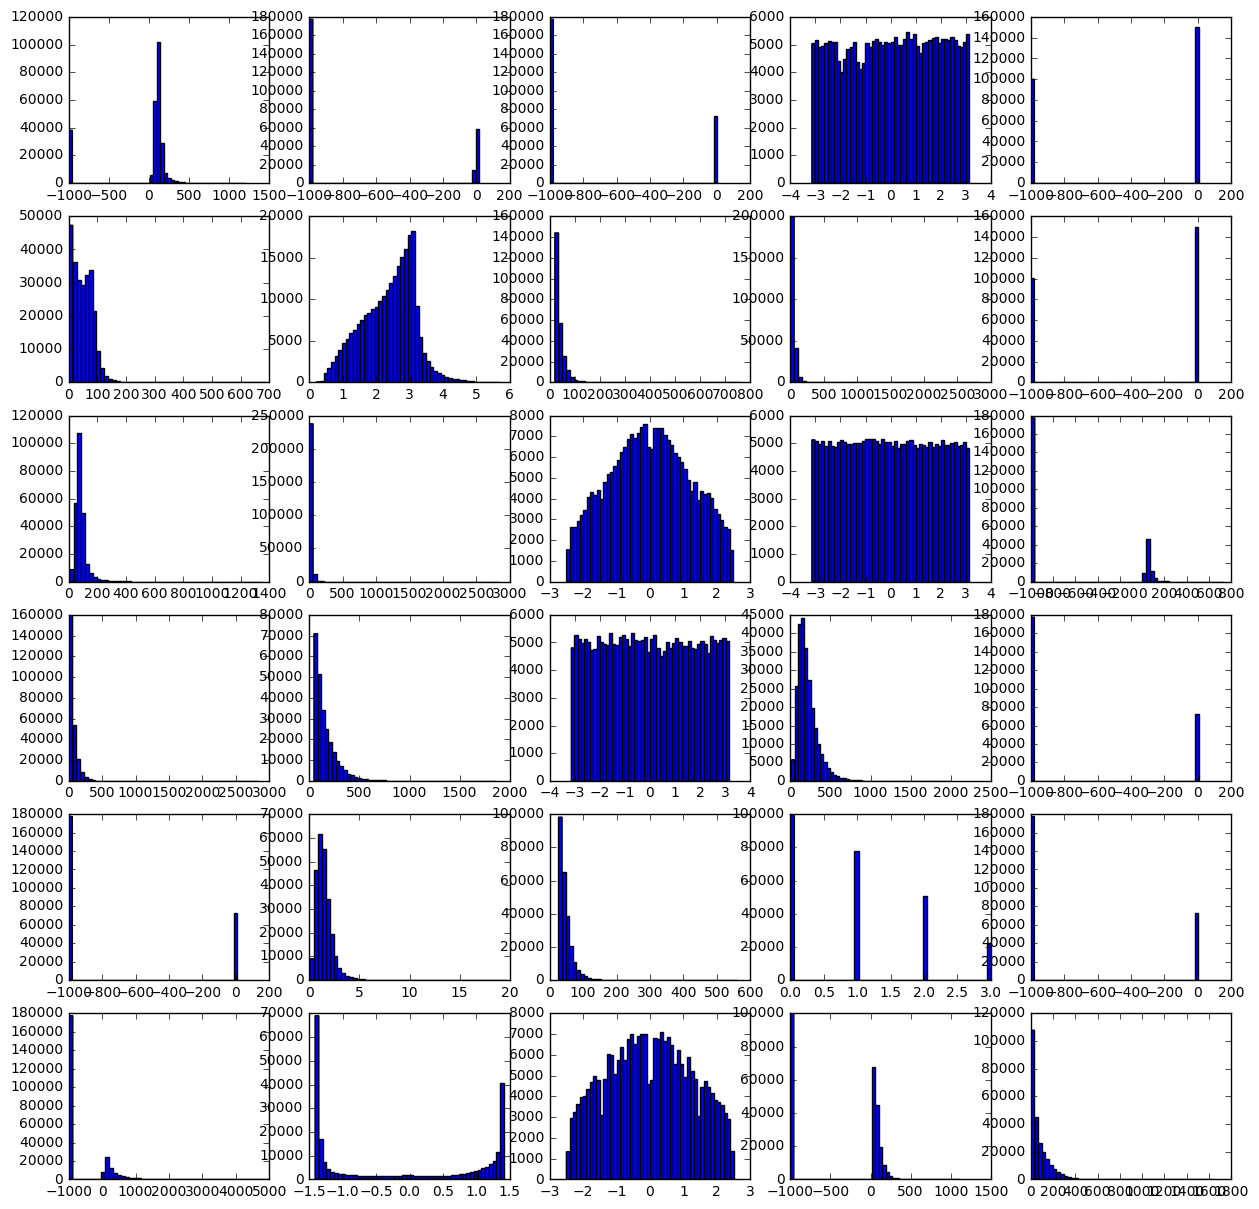

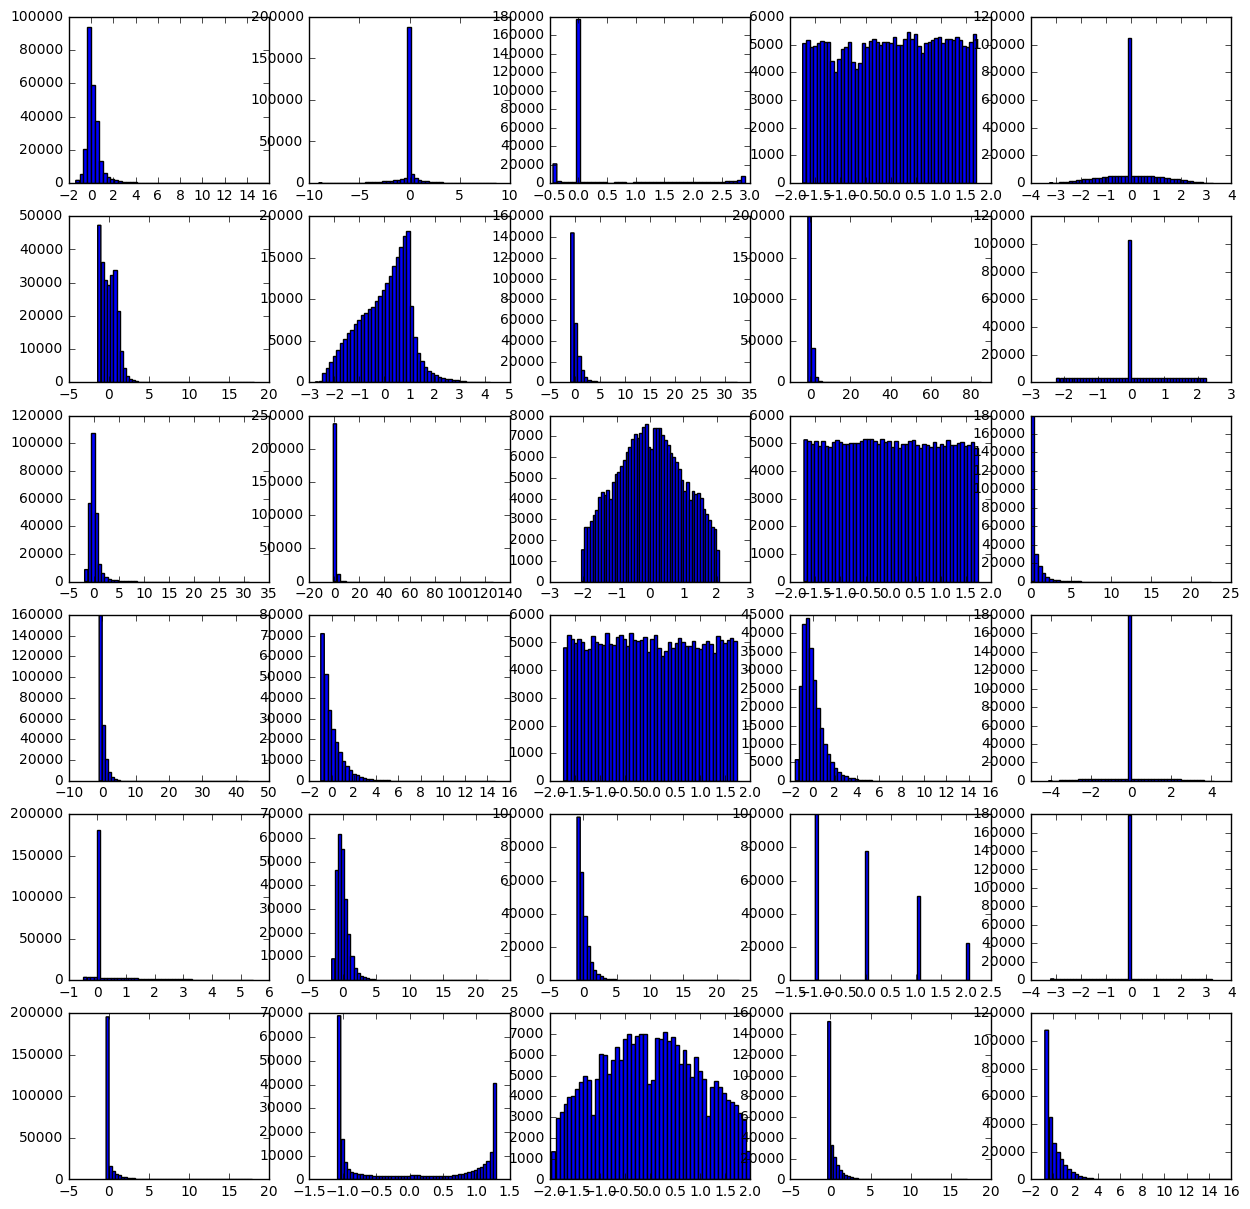

In [4]:
hist_res = 50

outlier_index= find_outlier(tX)
tX_clean = clean_data(tX,outlier_index)
tX_clean, _, _ = standardize(tX_clean, None, None)
tX_clean = clean_data(tX_clean,outlier_index)

f, axarr = plt.subplots(6, 5);
f.set_figheight(15)
f.set_figwidth(15)

for i in range(5):
    for j in range(6):
        axarr[j,i].hist(tX[:,j+i*6], bins=hist_res);

g, axarr2 = plt.subplots(6, 5);
g.set_figheight(15)
g.set_figwidth(15)

for i in range(5):
    for j in range(6):
        axarr2[j,i].hist(tX_clean[:,j+i*6], bins=hist_res);
        

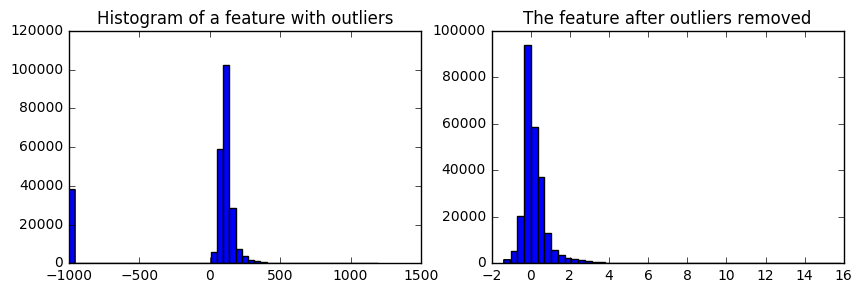

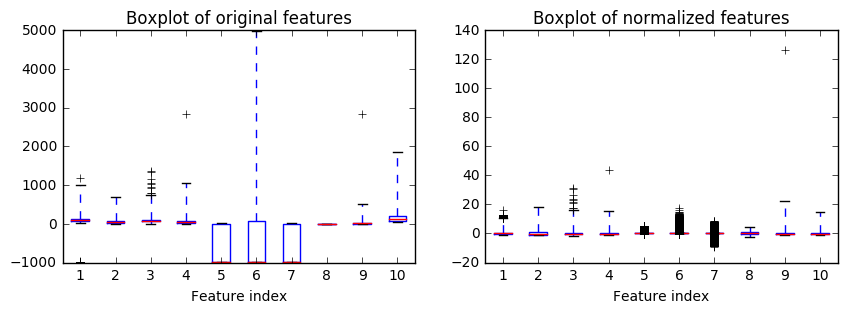

In [5]:
f, axarr = plt.subplots(1, 2);

axarr[0].hist(tX[:,0],bins=hist_res);
axarr[0].set_title('Histogram of a feature with outliers');
#axarr[0].set_xlabel('');

axarr[1].hist(tX_clean[:,0],bins=hist_res);
axarr[1].set_title('The feature after outliers removed');
#axarr[1].set_xlabel('Feature index');

f.set_figheight(3)
f.set_figwidth(10)

f, axarr = plt.subplots(1, 2);

axarr[0].boxplot(tX[:,0:10],whis=20.0);
axarr[0].set_title('Boxplot of original features');
axarr[0].set_xlabel('Feature index');

axarr[1].boxplot(tX_clean[:,0:10],whis=20.0);
axarr[1].set_title('Boxplot of normalized features');
axarr[1].set_xlabel('Feature index');

f.set_figheight(3)
f.set_figwidth(10)




In [6]:
from costs import compute_loss
from helpers import batch_iter

def build_k_indices(N, k_fold, seed):
    """build k indices for k-fold."""
    num_row = N
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def sigmoid(t):
    """apply sigmoid function on t."""
    expo = np.exp(t)
    sigm = expo/(1+expo)
    if np.inf in expo:
        # print("EXP OVERFLOW!!")
        for i, x in enumerate(expo):
            if x == np.inf:
                sigm[i] = 1.0
    return sigm

def calculate_log(y, tx, w):
    """compute the cost by negative log likelihood."""
    loss = sum( np.log(1+np.exp(np.dot(tx,w))) - np.multiply(y,np.dot(tx,w)) )
    if loss==np.inf:
        loss = sum( np.dot(tx,w) - np.multiply(y,np.dot(tx,w)) )
        print("LOSS OVERFLOW!!")
    return loss

def calculate_log_gradient(y, tx, w):
    """compute the gradient of loss."""
    return np.dot(tx.T,sigmoid(np.dot(tx,w))-y)

def mult_diag(A,d):
    N=A.shape[0]
    D=A.shape[1]
    res = np.empty(A.shape)
    for i in range(N):
        res[i,:] = np.multiply(A[i,:],d)
    return res
    
def calculate_hessian(y, tx, w):
    """return the hessian of the loss function."""
    N = tx.shape[0]
    D = tx.shape[1]
    
    S = np.zeros([N])
    for n in range(N):
        sigm = sigmoid(np.dot(tx[n,:],w))
        S[n] = sigm*(1-sigm)
        
    return np.dot(mult_diag(tx.T,S),tx)

def log_gradient_descent_newton(y, tx, w, gamma, lambda_):
    loss = calculate_log(y, tx, w)
    grad = calculate_log_gradient(y, tx, w)
    hessian = calculate_hessian(y, tx, w)
    w = w - gamma * np.dot(np.linalg.inv( hessian+lambda_*np.eye(hessian.shape[0]) ), grad) 
    return loss,w

def logistic_regression_newton(y, tx, gamma, lambda_, max_iter):
    w = np.zeros((tx.shape[1],1))
    for iter in range(max_iter):
        loss,w = log_gradient_descent_newton(y, tx, w, gamma, lambda_)
        print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
    return loss,w

In [8]:
poly_range = [1, 3, 5, 9]
acc_poly = [[],[],[],[]]
for poly_i, poly_degree in iter(poly_range):

    tX_train,tX_test_proc = feature_process(tX, tX_test, poly_degree)
    y_train = np.array([1 if i==1 else 0 for i in y])

    N = tX_train.shape[0]
    print(N)
    D = tX_train.shape[1]
    print(D)

    seed = 1
    k_fold = 4
    k_indices = build_k_indices(N, k_fold, seed)

    N_fold = N * (k_fold-1) / k_fold
    N_test = N / k_fold

    max_iters = 70
    # batch_size = 1000

    max_acc = 0
    opt_gamma = 0
    acc_avg = []
    acc = []
    ind=0

    ws=np.zeros( (D, k_fold) )

    lambda_range = np.logspace(2,-6,10)
    for lambda_i, lambda_ in lambda_range:
        # gamma_range = np.linspace(0.001, 0.0001, 10)
        # gamma_range = np.logspace(0, -1, 5)
        gamma_range=[ 0.1 ]
        for gamma in gamma_range:
            acc.append([])
            for k in range(k_fold):
                yTr=np.zeros( (N_fold,1) )
                xTr=np.zeros( (N_fold,D) )
                st_ind=0
                for i in range(k_fold):
                    if i==k:
                        yTe = y_train[k_indices[i]]
                        xTe = tX_train[k_indices[i]]
                    else:
                        yTr[st_ind:st_ind+N/k_fold,0] = y_train[k_indices[i]]
                        xTr[st_ind:st_ind+N/k_fold] = tX_train[k_indices[i]]
                        st_ind = st_ind + N/k_fold

                ## Logistic regression
                loss, w = logistic_regression_newton(yTr, xTr, gamma, lambda_, max_iters)
                y_est = sigmoid(np.dot(xTe,w))
                y_label = [0 if i<0.5 else 1 for i in y_est]
                ws[:,k:k+1] = w
                corr = [True if i==yTe[ind] else False for ind, i in enumerate(y_label)]
                acc[ind].append(sum(corr)/N_test)
                print("Fold: {f}, Accuracy: {acc}, Loss:{loss}".format(f=k, acc=acc[ind][k], loss=loss))
            acc_avg.append(sum(acc[ind])/k_fold)
            print("Gamma: {gamma}, Average Accuracy: {acc}".format(gamma=gamma, acc=acc_avg[ind]))    
            if acc_avg[ind]>max_acc:
                max_acc = acc_avg[ind]
                opt_gamma = gamma
            ind=ind+1
            
        acc_poly[poly_i].append(max_acc)    
        print("Maximum Accuracy: {max_acc}, Optimal Gamma: {opt_gamma}".format(max_acc=max_acc, opt_gamma=opt_gamma))         
        plt.boxplot(acc,labels = gamma_range);

        weights=np.zeros([D,1])
        for d in range(D):
            weights[d,0] = sum(ws[d,:])/k_fold  

NameError: name 'iterate' is not defined

## Generate predictions and save ouput in csv format for submission:

In [ ]:
OUTPUT_PATH = '/home/acy/PCML/projects/project1/predictions.csv' # TODO: fill in desired name of output file for submission
y_est = sigmoid(np.dot(tX_test_proc,weights))
y_pred = np.array([-1 if i<0.5 else 1 for i in y_est])
#y_pred = predict_labels(weights, tX_test_proc)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)